# Machine Learning in Finance (Seminar) - Group 1

## 1 Imports

### 1.1 Python imports

In [144]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys
!{sys.executable} -m pip install nbimporter

import nbimporter
from Helpers import helper_functions
from sklearn.model_selection import train_test_split

import sys
!{sys.executable} -m pip install imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import datetime
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

### 1.2 Data imports

Reading the five datasets from the Data folder (The files were downloaded from Kaggle and uploaded to the repository manually). We than add the additional column 'SP500' to every dataframe including the annual performance of the SP500 according to this source: https://www.macrotrends.net/2526/sp-500-historical-annual-returns. We there downloaded the historical data on Thursday, 04.03.2021. The corresponding file 'sp-500-historical-annual-returns.csv' can be found in our folder 'Data'.

In [145]:
#load data sets
df_2014 = pd.read_csv('Data/2014_Financial_Data.csv')
df_2015 = pd.read_csv('Data/2015_Financial_Data.csv')
df_2016 = pd.read_csv('Data/2016_Financial_Data.csv')
df_2017 = pd.read_csv('Data/2017_Financial_Data.csv')
df_2018 = pd.read_csv('Data/2018_Financial_Data.csv')

#load S&P-500 data set
df_SP500 = pd.read_csv('Data/sp-500-historical-annual-returns.csv')

## 2 Dataset Preparation

### 2.1 Organising Data Frames

In [146]:
#rename price variation columns for later concatenation of the different data frames
df_2014 = df_2014.rename(columns={"2015 PRICE VAR [%]": "PRICE VAR [%]"})
df_2015 = df_2015.rename(columns={"2016 PRICE VAR [%]": "PRICE VAR [%]"})
df_2016 = df_2016.rename(columns={"2017 PRICE VAR [%]": "PRICE VAR [%]"})
df_2017 = df_2017.rename(columns={"2018 PRICE VAR [%]": "PRICE VAR [%]"})
df_2018 = df_2018.rename(columns={"2019 PRICE VAR [%]": "PRICE VAR [%]"})

#drop row entries consisting of only nan values
df_2014.dropna(how = 'all', inplace = True)
df_2015.dropna(how = 'all', inplace = True)
df_2016.dropna(how = 'all', inplace = True)
df_2017.dropna(how = 'all', inplace = True)
df_2018.dropna(how = 'all', inplace = True)

#drop class column and name of share column
df_2014 = df_2014.drop(columns = ['Class', 'Unnamed: 0'])
df_2015 = df_2015.drop(columns = ['Class', 'Unnamed: 0'])
df_2016 = df_2016.drop(columns = ['Class', 'Unnamed: 0'])
df_2017 = df_2017.drop(columns = ['Class', 'Unnamed: 0'])
df_2018 = df_2018.drop(columns = ['Class', 'Unnamed: 0'])

Firstly, we want to get an overview of the data which we deal with. One important property is the Sector and their distribution.

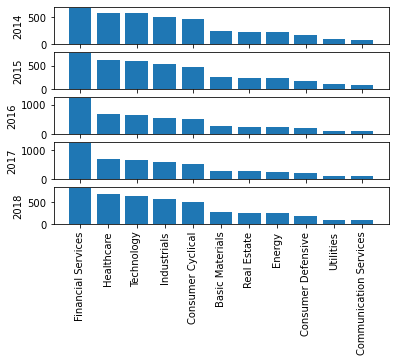

In [147]:
#Plotting the sector distributions
df_2014_sector = df_2014['Sector'].value_counts()
df_2015_sector = df_2015['Sector'].value_counts()
df_2016_sector = df_2016['Sector'].value_counts()
df_2017_sector = df_2017['Sector'].value_counts()
df_2018_sector = df_2018['Sector'].value_counts()
       
plt.title('Observations Sector Distribution', fontsize=20)
plt.subplot(5, 1, 1)
year_2014 = plt.bar(np.arange(len(df_2014_sector)), df_2014_sector)
plt.ylabel('2014')

plt.subplot(5, 1, 2)
year_2015 = plt.bar(np.arange(len(df_2015_sector)), df_2015_sector)
plt.ylabel('2015')

plt.subplot(5, 1, 3)
year_2016 = plt.bar(np.arange(len(df_2016_sector)), df_2016_sector)
plt.ylabel('2016')

plt.subplot(5, 1, 4)
year_2017 = plt.bar(np.arange(len(df_2017_sector)), df_2017_sector)
plt.ylabel('2017')

plt.subplot(5,1,5)
year_2018 = plt.bar(np.arange(len(df_2018_sector)), df_2018_sector)
plt.ylabel('2018')
plt.xticks(np.arange(len(df_2018_sector)), df_2018_sector.index.values.tolist(), rotation = 90)

plt.show()

We clearly see that some Sectors appear more often than others. And we also see that the dataframes don't have the same size. We decide to add boolean columns for all years. These year columns and the Sector will be part of our most important features.

In [148]:
#add year columns as booleans
df_2014['year_2014'] = 1
df_2014['year_2015'] = 0
df_2014['year_2016'] = 0
df_2014['year_2017'] = 0
df_2014['year_2018'] = 0

df_2015['year_2014'] = 0
df_2015['year_2015'] = 1
df_2015['year_2016'] = 0
df_2015['year_2017'] = 0
df_2015['year_2018'] = 0

df_2016['year_2014'] = 0
df_2016['year_2015'] = 0
df_2016['year_2016'] = 1
df_2016['year_2017'] = 0
df_2016['year_2018'] = 0

df_2017['year_2014'] = 0
df_2017['year_2015'] = 0
df_2017['year_2016'] = 0
df_2017['year_2017'] = 1
df_2017['year_2018'] = 0

df_2018['year_2014'] = 0
df_2018['year_2015'] = 0
df_2018['year_2016'] = 0
df_2018['year_2017'] = 0
df_2018['year_2018'] = 1

Obviously, our Sector-column will be important as well. We therefore factorize the categorical value and now have one column per Sector which appears in the data set.

In [149]:
#Factorize categorical value "Sector"
df_Sector_Columns_2014 = pd.get_dummies(df_2014['Sector'])
df_Sector_Columns_2015 = pd.get_dummies(df_2015['Sector'])
df_Sector_Columns_2016 = pd.get_dummies(df_2016['Sector'])
df_Sector_Columns_2017 = pd.get_dummies(df_2017['Sector'])
df_Sector_Columns_2018 = pd.get_dummies(df_2018['Sector'])

#merge dfs
df_2014_factorized = pd.concat([df_2014, df_Sector_Columns_2014], axis=1)
df_2015_factorized = pd.concat([df_2015, df_Sector_Columns_2015], axis=1)
df_2016_factorized = pd.concat([df_2016, df_Sector_Columns_2016], axis=1)
df_2017_factorized = pd.concat([df_2017, df_Sector_Columns_2017], axis=1)
df_2018_factorized = pd.concat([df_2018, df_Sector_Columns_2018], axis=1)

#delete the now useless sector column
del df_2014_factorized['Sector']
del df_2015_factorized['Sector']
del df_2016_factorized['Sector']
del df_2017_factorized['Sector']
del df_2018_factorized['Sector']

### 2.2 Add response variable

As requested in the task we add a column for our response variable Strategy (Buy = 0, Hold = 1, Sell = 2). 

In [150]:
#add S&P500 performance for the following year to the dataframes
SP500_performance_2015 = df_SP500.value[87]
SP500_performance_2016 = df_SP500.value[88]
SP500_performance_2017 = df_SP500.value[89]
SP500_performance_2018 = df_SP500.value[90]
SP500_performance_2019 = df_SP500.value[91]

df_2014_factorized['SP500'] = SP500_performance_2015
df_2015_factorized['SP500'] = SP500_performance_2016
df_2016_factorized['SP500'] = SP500_performance_2017
df_2017_factorized['SP500'] = SP500_performance_2018
df_2018_factorized['SP500'] = SP500_performance_2019

#add Strategy column      
df_2014_factorized['Strategy'] = -1
df_2015_factorized['Strategy'] = -1
df_2016_factorized['Strategy'] = -1
df_2017_factorized['Strategy'] = -1
df_2018_factorized['Strategy'] = -1

#Fill Strategy column
for index in df_2014_factorized.index:
    df_2014_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2014_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2014_factorized['SP500'].values[index])
for index in df_2015_factorized.index:
    df_2015_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2015_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2015_factorized['SP500'].values[index])
for index in df_2016_factorized.index:
    df_2016_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2016_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2016_factorized['SP500'].values[index])
for index in df_2017_factorized.index:
    df_2017_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2017_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2017_factorized['SP500'].values[index])
for index in df_2018_factorized.index:
    df_2018_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2018_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2018_factorized['SP500'].values[index])




In [151]:
#OPTIONAL -- create csv to take a control look to a data frame
# e.g. 2016: uncomment following lines

#compression_opts = dict(method='zip', archive_name='2016.csv')  
#df_2016_factorized.to_csv('2016.zip', index=False,
#         compression=compression_opts) 

In [152]:

#remove S&P 500 column and PRICE VAR
columns_to_drop = ['SP500', 'PRICE VAR [%]']
df_2014_factorized = df_2014_factorized.drop(columns = columns_to_drop)
df_2015_factorized = df_2015_factorized.drop(columns = columns_to_drop)
df_2016_factorized = df_2016_factorized.drop(columns = columns_to_drop)
df_2017_factorized = df_2017_factorized.drop(columns = columns_to_drop)
df_2018_factorized = df_2018_factorized.drop(columns = columns_to_drop)

We take a first look at the Strategy distribution. We notice a clear class imbalance but a quite similar picture in every year. 

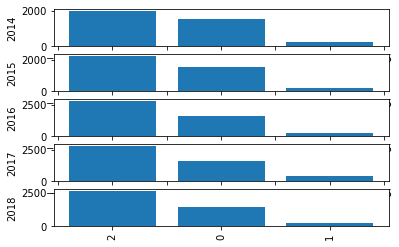

In [153]:
#Plotting the strategy distributions
df_2014_strategy = df_2014_factorized['Strategy'].value_counts()
df_2015_strategy = df_2015_factorized['Strategy'].value_counts()
df_2016_strategy = df_2016_factorized['Strategy'].value_counts()
df_2017_strategy = df_2017_factorized['Strategy'].value_counts()
df_2018_strategy = df_2018_factorized['Strategy'].value_counts()
       
plt.title('Strategy Distributions', fontsize=20)
plt.subplot(5, 1, 1)
year_2014 = plt.bar(np.arange(len(df_2014_strategy)), df_2014_strategy)
plt.ylabel('2014')

plt.subplot(5, 1, 2)
year_2015 = plt.bar(np.arange(len(df_2015_strategy)), df_2015_strategy)
plt.ylabel('2015')

plt.subplot(5, 1, 3)
year_2016 = plt.bar(np.arange(len(df_2016_strategy)), df_2016_strategy)
plt.ylabel('2016')

plt.subplot(5, 1, 4)
year_2017 = plt.bar(np.arange(len(df_2017_strategy)), df_2017_strategy)
plt.ylabel('2017')

plt.subplot(5,1,5)
year_2018 = plt.bar(np.arange(len(df_2018_strategy)), df_2018_strategy)
plt.ylabel('2018')
plt.xticks(np.arange(len(df_2018_strategy)), df_2018_strategy.index.values.tolist(), rotation = 90)

plt.show()

## 2.3 Handling missing values

### 2.3.1 Columns

Financial Data 2014 - zero values

In [154]:
#Identification of missing and zero values
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#Check zero values per column
percentage_of_zeroes_2014 = round(df_2014_factorized[df_2014_factorized == 0].count(axis = 0) * 100 / len(df_2014_factorized), 1)
df_zeroes_2014 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2014})
df_zeroes_2014.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

print(df_zeroes_2014)

                                            Percentage of Zero Values
year_2018                                                       100.0
year_2015                                                       100.0
year_2016                                                       100.0
year_2017                                                       100.0
Communication Services                                           97.8
Utilities                                                        97.5
Consumer Defensive                                               95.7
Energy                                                           94.2
Real Estate                                                      94.1
Basic Materials                                                  93.6
Consumer Cyclical                                                88.0
Industrials                                                      86.8
Technology                                                       84.9
Healthcare          

Financial Data 2014 - nan values

In [155]:
#Check nan values per column
percentage_of_nan_2014 = round(df_2014_factorized.isnull().sum() * 100 / len(df_2014_factorized), 1)
df_nan_2014 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2014})
df_nan_2014.sort_values('Percentage of nan Values', inplace = True, ascending = False)

print(df_nan_2014)

                                            Percentage of nan Values
operatingCycle                                                 100.0
cashConversionCycle                                            100.0
shortTermCoverageRatios                                         51.4
cashFlowCoverageRatios                                          41.9
cashFlowToDebtRatio                                             41.9
10Y Shareholders Equity Growth (per Share)                      41.6
10Y Net Income Growth (per Share)                               40.6
10Y Revenue Growth (per Share)                                  40.6
10Y Operating CF Growth (per Share)                             40.3
10Y Dividend per Share Growth (per Share)                       38.5
Net Debt to EBITDA                                              37.4
dividendPayoutRatio                                             34.0
priceEarningsToGrowthRatio                                      34.0
Other Assets                      

Besides just getting a first feel for our data set concerning zero and nan values, we also took a closer look at features with extreme or identical percentage values.

Hereby we discovered a great amount of duplicate columns and other useless features, which are removed next. As all the data sets consist of the same columns, these will also be removed in the 2015-2018 data sets.

As the fractions of zero and nan values may, and most certainly will vary from one year to another, we decided to drop columns due to their overstepping of a certain threshold after combining the cleaned data sets.

### 2.3.1.1 Drop columns – Unnecessary features

In [156]:
useless_feature_columns = ['cashConversionCycle', 'operatingCycle', 'operatingProfitMargin']

duplicates = ['priceToSalesRatio', 'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio', \
              'dividendYield', 'ebitperRevenue', 'grossProfitMargin', 'returnOnEquity', 'returnOnCapitalEmployed', \
              'eBTperEBIT', 'eBITperRevenue', 'payablesTurnover', 'inventoryTurnover', 'currentRatio', \
              'daysOfPayablesOutstanding', 'debtEquityRatio', 'interestCoverage', 'payoutRatio', 'dividendPayoutRatio', \
              'niperEBT', 'cashFlowCoverageRatios', 'Return on Tangible Assets', 'PTB ratio', 'PB ratio', \
              'Cash per Share', 'Operating Cash Flow per Share', 'Debt to Assets']

columns_to_drop = useless_feature_columns + duplicates

df_2014_factorized = df_2014_factorized.drop(columns = columns_to_drop)
df_2015_factorized = df_2015_factorized.drop(columns = columns_to_drop)
df_2016_factorized = df_2016_factorized.drop(columns = columns_to_drop)
df_2017_factorized = df_2017_factorized.drop(columns = columns_to_drop)
df_2018_factorized = df_2018_factorized.drop(columns = columns_to_drop)

### 2.3.1.2 Drop columns – Zero values

Financial Data 2014 - zero values

In [157]:
#Check zero values per column
percentage_of_zeroes_2014 = round(df_2014_factorized[df_2014_factorized == 0].count(axis = 0) * 100 / len(df_2014_factorized), 1)
df_zeroes_2014 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2014})
df_zeroes_2014.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2014)

Financial Data 2015 - zero values

In [158]:
#Check zero values per column
percentage_of_zeroes_2015 = round(df_2015_factorized[df_2015_factorized == 0].count(axis = 0) * 100 / len(df_2015_factorized), 1)
df_zeroes_2015 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2015})
df_zeroes_2015.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2015)

Financial Data 2016 - zero values

In [159]:
#Check zero values per column
percentage_of_zeroes_2016 = round(df_2016_factorized[df_2016_factorized == 0].count(axis = 0) * 100 / len(df_2016_factorized), 1)
df_zeroes_2016 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2016})
df_zeroes_2016.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2016)

Financial Data 2017 - zero values

In [160]:
#Check zero values per column
percentage_of_zeroes_2017 = round(df_2017_factorized[df_2017_factorized == 0].count(axis = 0) * 100 / len(df_2017_factorized), 1)
df_zeroes_2017 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2017})
df_zeroes_2017.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2017)

Financial Data 2018 - zero values

In [161]:
#Check zero values per column
percentage_of_zeroes_2018 = round(df_2018_factorized[df_2018_factorized == 0].count(axis = 0) * 100 / len(df_2018_factorized), 1)
df_zeroes_2018 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2018})
df_zeroes_2018.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2018)

When comparing the Zero Value Percentage Columns, corrected from the factorized sector columns, then we can see, that there are the following columns present with a threshold of more than 50%:

2014: <br>
Preferred Dividends                                              (83.7)<br>
Net Income - Discontinued ops                                    (80.0)<br>
Deposit Liabilities                                              (79.6)<br>
R&D to Revenue                                                   (65.0)<br>
Net Income - Non-Controlling int                                 (64.4)<br>
Deferred revenue                                                 (62.4)<br>
R&D Expenses                                                     (61.5)<br>
R&D Expense Growth                                               (60.0)<br>
Dividends per Share Growth                                       (57.3)<br>
Effect of forex changes on cash                                  (51.4)<br>
3Y Dividend per Share Growth (per Share)                         (51.1)<br>
Dividend Yield                                                   (50.5)<br>
Dividend per Share                                               (50.3)<br>
<br>
<br>
2015: <br>
Preferred Dividends                                              (81.8)<br>
Net Income - Discontinued ops                                    (80.0)<br>
Deposit Liabilities                                              (78.1)<br>
R&D to Revenue                                                   (62.5)<br>
Net Income - Non-Controlling int                                 (62.3)<br>
Deferred revenue                                                 (60.8)<br>
R&D Expenses                                                     (59.1)<br>
Short-term investments                                           (58.5)<br>
R&D Expense Growth                                               (58.3)<br>
Dividends per Share Growth                                       (55.9)<br>
<br>
<br>
2016:<br>
Preferred Dividends                                              (75.0)<br>
Net Income - Discontinued ops                                    (74.2)<br>
Deposit Liabilities                                              (71.3)<br>
Net Income - Non-Controlling int                                 (57.2)<br>
R&D to Revenue                                                   (56.7)<br>
Deferred revenue                                                 (55.2)<br>
Short-term investments                                           (54.7)<br>
R&D Expenses                                                     (53.4)<br>
R&D Expense Growth                                               (52.8)<br>
Dividends per Share Growth                                       (52.7)<br>
<br>
<br>
2017:<br>
Net Income - Discontinued ops                                    (74.2)<br>
Preferred Dividends                                              (73.3)<br>
Deposit Liabilities                                              (70.4)<br>
Net Income - Non-Controlling int                                 (56.0)<br>
R&D to Revenue                                                   (55.7)<br>
Deferred revenue                                                 (55.4)<br>
Short-term investments                                           (53.8)<br>
Dividends per Share Growth                                       (53.0)<br>
R&D Expenses                                                     (52.5)<br>
R&D Expense Growth                                               (52.2)<br>
<br>
<br>
2018:<br>
Preferred Dividends                                              (83.5)<br>
Deposit Liabilities                                              (79.8)<br>
Deferred revenue                                                 (64.2)<br>
R&D to Revenue                                                   (63.1)<br>
Net Income - Non-Controlling int                                 (63.0)<br>
Short-term investments                                           (59.7)<br>
R&D Expenses                                                     (59.6)<br>
R&D Expense Growth                                               (59.4)<br>
Dividends per Share Growth                                       (58.4)<br>
3Y Dividend per Share Growth (per Share)                         (55.1)<br>
Tax assets                                                       (52.6)<br>
<br>
<br>
Due to these findings, we decided to further remove from all data sets the following columns

In [162]:
zero_value_drops = ['Preferred Dividends', 'Net Income - Discontinued ops', 'Deposit Liabilities', 'Deferred revenue', \
                   'Net Income - Non-Controlling int', 'R&D to Revenue', 'R&D Expenses', 'Short-term investments', \
                   'R&D Expense Growth', 'Dividends per Share Growth']

df_2014_factorized = df_2014_factorized.drop(columns = zero_value_drops)
df_2015_factorized = df_2015_factorized.drop(columns = zero_value_drops)
df_2016_factorized = df_2016_factorized.drop(columns = zero_value_drops)
df_2017_factorized = df_2017_factorized.drop(columns = zero_value_drops)
df_2018_factorized = df_2018_factorized.drop(columns = zero_value_drops)

### 2.3.1.2 Drop columns – NaN values

Financial Data 2014 - NaN values

In [163]:
#Check nan values per column
percentage_of_nan_2014 = round(df_2014_factorized.isnull().sum() * 100 / len(df_2014_factorized), 1)
df_nan_2014 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2014})
df_nan_2014.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2014)

Financial Data 2015 - NaN values

In [164]:
#Check nan values per column
percentage_of_nan_2015 = round(df_2015_factorized.isnull().sum() * 100 / len(df_2015_factorized), 1)
df_nan_2015 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2015})
df_nan_2015.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2015)

Financial Data 2016 - NaN values

In [165]:
#Check nan values per column
percentage_of_nan_2016 = round(df_2016_factorized.isnull().sum() * 100 / len(df_2016_factorized), 1)
df_nan_2016 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2016})
df_nan_2016.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2016)

Financial Data 2017 - NaN values

In [166]:
#Check nan values per column
percentage_of_nan_2017 = round(df_2017_factorized.isnull().sum() * 100 / len(df_2017_factorized), 1)
df_nan_2017 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2017})
df_nan_2017.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2017)

Financial Data 2018 - NaN values

In [167]:
#Check nan values per column
percentage_of_nan_2018 = round(df_2018_factorized.isnull().sum() * 100 / len(df_2018_factorized), 1)
df_nan_2018 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2018})
df_nan_2018.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2018)

When comparing the NaN Value Percentage Columns we can see, that there are the following columns present with a threshold of missing values above 40%:

2014: <br>
shortTermCoverageRatios                                         51.4<br>
cashFlowToDebtRatio                                             41.9<br>
10Y Shareholders Equity Growth (per Share)                      41.6<br>
10Y Revenue Growth (per Share)                                  40.6<br>
10Y Net Income Growth (per Share)                               40.6<br>
10Y Operating CF Growth (per Share)                             40.3<br>
<br>
<br>
2015: <br>
shortTermCoverageRatios                                         46.7<br>
10Y Shareholders Equity Growth (per Share)                      42.9<br>
10Y Revenue Growth (per Share)                                  42.2<br>
10Y Net Income Growth (per Share)                               42.2<br>
10Y Operating CF Growth (per Share)                             41.9<br>
<br>
<br>
2016: <br>
shortTermCoverageRatios                                         50.4<br>
10Y Shareholders Equity Growth (per Share)                      47.7<br>
10Y Net Income Growth (per Share)                               47.4<br>
10Y Revenue Growth (per Share)                                  47.4<br>
10Y Operating CF Growth (per Share)                             47.1<br>
priceEarningsToGrowthRatio                                      46.2<br>
10Y Dividend per Share Growth (per Share)                       46.1<br>
Net Debt to EBITDA                                              44.1<br>
nIperEBT                                                        43.5<br>
effectiveTaxRate                                                43.5<br>
ebtperEBIT                                                      41.4<br>
Net Debt                                                        40.5<br>
Other Assets                                                    40.3<br>
<br>
<br>
2017: <br>
shortTermCoverageRatios                                         50.8<br>
10Y Shareholders Equity Growth (per Share)                      47.3<br>
10Y Net Income Growth (per Share)                               46.8<br>
10Y Revenue Growth (per Share)                                  46.8<br>
10Y Operating CF Growth (per Share)                             46.6<br>
10Y Dividend per Share Growth (per Share)                       45.8<br>
priceEarningsToGrowthRatio                                      45.6<br>
Net Debt to EBITDA                                              44.4<br>
effectiveTaxRate                                                43.2<br>
nIperEBT                                                        43.2<br>
ebtperEBIT                                                      41.0<br>
<br>
<br>
2018: <br>
shortTermCoverageRatios                                         43.9<br>
<br>
<br>
Due to these findings, we decided to further remove from all data sets the following columns

In [168]:
nan_values_drop = ['shortTermCoverageRatios', '10Y Shareholders Equity Growth (per Share)', \
                   '10Y Net Income Growth (per Share)', '10Y Revenue Growth (per Share)', \
                  '10Y Operating CF Growth (per Share)', '10Y Dividend per Share Growth (per Share)']

df_2014_factorized = df_2014_factorized.drop(columns = nan_values_drop)
df_2015_factorized = df_2015_factorized.drop(columns = nan_values_drop)
df_2016_factorized = df_2016_factorized.drop(columns = nan_values_drop)
df_2017_factorized = df_2017_factorized.drop(columns = nan_values_drop)
df_2018_factorized = df_2018_factorized.drop(columns = nan_values_drop)

When looking at the dropped columns above, it also makes sense, in our opinion, from an economical point of view to drop these 10 year metrics, as we see such a long period as too long to be of any use.

### 2.3.2 Rows

We decided to delete rows which still have more than 42 NaN values. I.e. all rows need at least 150 Non-NaN-values in their 192 columns (77.7%).
We therefore delete 2491 out of 22077 rows (11.3 %).

In [169]:
#delete rows which have less than 150 non-NaN values
df_2014_factorized.dropna(axis=0, thresh=150, inplace=True)
df_2015_factorized.dropna(axis=0, thresh=150, inplace=True)
df_2016_factorized.dropna(axis=0, thresh=150, inplace=True)
df_2017_factorized.dropna(axis=0, thresh=150, inplace=True)
df_2018_factorized.dropna(axis=0, thresh=150, inplace=True)

## 2.4 Outlier Handling

We decided to handle possible outliers on a per year data set level. Furthermore, it is in our opinion of importance to do this task sectorwise. We define the upper 5 and lower 5 percent of all values in every year and sector as outliers and replace it with the corresponding threshold.

In [170]:
upper_quantile_threshold = 0.95
lower_quantile_threshold = 0.05

Financial Data 2014

In [171]:
#OPTIONAL check if Outlier handling works (see below as well)
#df_2014_factorized[df_2014_factorized['Consumer Defensive']==1].describe()

In [172]:
df_2014_sectors_strategy = df_2014_factorized.iloc[:, -12:]
df_2014_factorized_copy = df_2014_factorized.drop(columns = ['Consumer Cyclical', 'Consumer Defensive', \
                                                            'Energy', 'Financial Services', 'Healthcare', 'Industrials', \
                                                            'Real Estate', 'Technology', 'Utilities', 'Basic Materials', \
                                                             'Communication Services', 'Strategy'])

df_2014_CD = df_2014_factorized_copy[df_2014_factorized['Consumer Defensive'] == 1]
df_2014_BM = df_2014_factorized_copy[df_2014_factorized['Basic Materials'] == 1]
df_2014_HC = df_2014_factorized_copy[df_2014_factorized['Healthcare'] == 1]
df_2014_CC = df_2014_factorized_copy[df_2014_factorized['Consumer Cyclical'] == 1]
df_2014_IN = df_2014_factorized_copy[df_2014_factorized['Industrials'] == 1]
df_2014_RE = df_2014_factorized_copy[df_2014_factorized['Real Estate'] == 1]
df_2014_CS = df_2014_factorized_copy[df_2014_factorized['Communication Services'] == 1]
df_2014_EN = df_2014_factorized_copy[df_2014_factorized['Energy'] == 1]
df_2014_FS = df_2014_factorized_copy[df_2014_factorized['Financial Services'] == 1]
df_2014_UT = df_2014_factorized_copy[df_2014_factorized['Utilities'] == 1]
df_2014_TE = df_2014_factorized_copy[df_2014_factorized['Technology'] == 1]

top_quantiles = df_2014_CD.quantile(upper_quantile_threshold)
outliers_top = (df_2014_CD > top_quantiles)
low_quantiles = df_2014_CD.quantile(lower_quantile_threshold)
outliers_low = (df_2014_CD < low_quantiles)
df_2014_CD = df_2014_CD.mask(outliers_top, top_quantiles, axis=1)
df_2014_CD = df_2014_CD.mask(outliers_low, low_quantiles, axis=1)


dfs_to_check_2014 = [df_2014_CD, df_2014_BM, df_2014_HC, df_2014_CC, df_2014_IN, df_2014_RE, df_2014_CS, \
                     df_2014_EN, df_2014_FS, df_2014_UT, df_2014_TE]

new_2014_dfs = []

for i in range(len(dfs_to_check_2014)):
    df_deep_copy = dfs_to_check_2014[i].copy(deep = True)
    top_quantiles = df_deep_copy.quantile(upper_quantile_threshold)
    outliers_top = (df_deep_copy > top_quantiles)

    low_quantiles = df_deep_copy.quantile(lower_quantile_threshold)
    outliers_low = (df_deep_copy < low_quantiles)

    df_deep_copy = df_deep_copy.mask(outliers_top, top_quantiles, axis=1)
    df_deep_copy = df_deep_copy.mask(outliers_low, low_quantiles, axis=1)
    
    new_2014_dfs.append(df_deep_copy)

df_2014_factorized = pd.concat(new_2014_dfs)
df_2014_factorized['Consumer Cyclical'] = df_2014_sectors_strategy['Consumer Cyclical']
df_2014_factorized['Consumer Defensive'] = df_2014_sectors_strategy['Consumer Defensive']
df_2014_factorized['Energy'] = df_2014_sectors_strategy['Energy']
df_2014_factorized['Financial Services'] = df_2014_sectors_strategy['Financial Services']
df_2014_factorized['Healthcare'] = df_2014_sectors_strategy['Healthcare']
df_2014_factorized['Industrials'] = df_2014_sectors_strategy['Industrials']
df_2014_factorized['Real Estate'] = df_2014_sectors_strategy['Real Estate']
df_2014_factorized['Technology'] = df_2014_sectors_strategy['Technology']
df_2014_factorized['Utilities'] = df_2014_sectors_strategy['Utilities']
df_2014_factorized['Basic Materials'] = df_2014_sectors_strategy['Basic Materials']
df_2014_factorized['Communication Services'] = df_2014_sectors_strategy['Communication Services']
df_2014_factorized['Strategy'] = df_2014_sectors_strategy['Strategy']

In [173]:
#OPTIONAL check if Outlier handling works (see above as well)
#df_2014_factorized[df_2014_factorized['Consumer Defensive']==1].describe()

Financial Data 2015

In [174]:
df_2015_sectors_strategy = df_2015_factorized.iloc[:, -12:]
df_2015_factorized_copy = df_2015_factorized.drop(columns = ['Consumer Cyclical', 'Consumer Defensive', \
                                                            'Energy', 'Financial Services', 'Healthcare', 'Industrials', \
                                                            'Real Estate', 'Technology', 'Utilities', 'Basic Materials', \
                                                             'Communication Services', 'Strategy'])

df_2015_CD = df_2015_factorized_copy[df_2015_factorized['Consumer Defensive'] == 1]
df_2015_BM = df_2015_factorized_copy[df_2015_factorized['Basic Materials'] == 1]
df_2015_HC = df_2015_factorized_copy[df_2015_factorized['Healthcare'] == 1]
df_2015_CC = df_2015_factorized_copy[df_2015_factorized['Consumer Cyclical'] == 1]
df_2015_IN = df_2015_factorized_copy[df_2015_factorized['Industrials'] == 1]
df_2015_RE = df_2015_factorized_copy[df_2015_factorized['Real Estate'] == 1]
df_2015_CS = df_2015_factorized_copy[df_2015_factorized['Communication Services'] == 1]
df_2015_EN = df_2015_factorized_copy[df_2015_factorized['Energy'] == 1]
df_2015_FS = df_2015_factorized_copy[df_2015_factorized['Financial Services'] == 1]
df_2015_UT = df_2015_factorized_copy[df_2015_factorized['Utilities'] == 1]
df_2015_TE = df_2015_factorized_copy[df_2015_factorized['Technology'] == 1]

top_quantiles = df_2015_CD.quantile(upper_quantile_threshold)
outliers_top = (df_2015_CD > top_quantiles)
low_quantiles = df_2015_CD.quantile(lower_quantile_threshold)
outliers_low = (df_2015_CD < low_quantiles)
df_2015_CD = df_2015_CD.mask(outliers_top, top_quantiles, axis=1)
df_2015_CD = df_2015_CD.mask(outliers_low, low_quantiles, axis=1)


dfs_to_check_2015 = [df_2015_CD, df_2015_BM, df_2015_HC, df_2015_CC, df_2015_IN, df_2015_RE, df_2015_CS, \
                     df_2015_EN, df_2015_FS, df_2015_UT, df_2015_TE]

new_2015_dfs = []

for i in range(len(dfs_to_check_2015)):
    df_deep_copy = dfs_to_check_2015[i].copy(deep = True)
    top_quantiles = df_deep_copy.quantile(upper_quantile_threshold)
    outliers_top = (df_deep_copy > top_quantiles)

    low_quantiles = df_deep_copy.quantile(lower_quantile_threshold)
    outliers_low = (df_deep_copy < low_quantiles)

    df_deep_copy = df_deep_copy.mask(outliers_top, top_quantiles, axis=1)
    df_deep_copy = df_deep_copy.mask(outliers_low, low_quantiles, axis=1)
    
    new_2015_dfs.append(df_deep_copy)

df_2015_factorized = pd.concat(new_2015_dfs)
df_2015_factorized['Consumer Cyclical'] = df_2015_sectors_strategy['Consumer Cyclical']
df_2015_factorized['Consumer Defensive'] = df_2015_sectors_strategy['Consumer Defensive']
df_2015_factorized['Energy'] = df_2015_sectors_strategy['Energy']
df_2015_factorized['Financial Services'] = df_2015_sectors_strategy['Financial Services']
df_2015_factorized['Healthcare'] = df_2015_sectors_strategy['Healthcare']
df_2015_factorized['Industrials'] = df_2015_sectors_strategy['Industrials']
df_2015_factorized['Real Estate'] = df_2015_sectors_strategy['Real Estate']
df_2015_factorized['Technology'] = df_2015_sectors_strategy['Technology']
df_2015_factorized['Utilities'] = df_2015_sectors_strategy['Utilities']
df_2015_factorized['Basic Materials'] = df_2015_sectors_strategy['Basic Materials']
df_2015_factorized['Communication Services'] = df_2015_sectors_strategy['Communication Services']
df_2015_factorized['Strategy'] = df_2015_sectors_strategy['Strategy']

Financial Data 2016

In [175]:
df_2016_sectors_strategy = df_2016_factorized.iloc[:, -12:]
df_2016_factorized_copy = df_2016_factorized.drop(columns = ['Consumer Cyclical', 'Consumer Defensive', \
                                                            'Energy', 'Financial Services', 'Healthcare', 'Industrials', \
                                                            'Real Estate', 'Technology', 'Utilities', 'Basic Materials', \
                                                             'Communication Services', 'Strategy'])

df_2016_CD = df_2016_factorized_copy[df_2016_factorized['Consumer Defensive'] == 1]
df_2016_BM = df_2016_factorized_copy[df_2016_factorized['Basic Materials'] == 1]
df_2016_HC = df_2016_factorized_copy[df_2016_factorized['Healthcare'] == 1]
df_2016_CC = df_2016_factorized_copy[df_2016_factorized['Consumer Cyclical'] == 1]
df_2016_IN = df_2016_factorized_copy[df_2016_factorized['Industrials'] == 1]
df_2016_RE = df_2016_factorized_copy[df_2016_factorized['Real Estate'] == 1]
df_2016_CS = df_2016_factorized_copy[df_2016_factorized['Communication Services'] == 1]
df_2016_EN = df_2016_factorized_copy[df_2016_factorized['Energy'] == 1]
df_2016_FS = df_2016_factorized_copy[df_2016_factorized['Financial Services'] == 1]
df_2016_UT = df_2016_factorized_copy[df_2016_factorized['Utilities'] == 1]
df_2016_TE = df_2016_factorized_copy[df_2016_factorized['Technology'] == 1]

top_quantiles = df_2016_CD.quantile(upper_quantile_threshold)
outliers_top = (df_2016_CD > top_quantiles)
low_quantiles = df_2016_CD.quantile(lower_quantile_threshold)
outliers_low = (df_2016_CD < low_quantiles)
df_2016_CD = df_2016_CD.mask(outliers_top, top_quantiles, axis=1)
df_2016_CD = df_2016_CD.mask(outliers_low, low_quantiles, axis=1)


dfs_to_check_2016 = [df_2016_CD, df_2016_BM, df_2016_HC, df_2016_CC, df_2016_IN, df_2016_RE, df_2016_CS, \
                     df_2016_EN, df_2016_FS, df_2016_UT, df_2016_TE]

new_2016_dfs = []

for i in range(len(dfs_to_check_2016)):
    df_deep_copy = dfs_to_check_2016[i].copy(deep = True)
    top_quantiles = df_deep_copy.quantile(upper_quantile_threshold)
    outliers_top = (df_deep_copy > top_quantiles)

    low_quantiles = df_deep_copy.quantile(lower_quantile_threshold)
    outliers_low = (df_deep_copy < low_quantiles)

    df_deep_copy = df_deep_copy.mask(outliers_top, top_quantiles, axis=1)
    df_deep_copy = df_deep_copy.mask(outliers_low, low_quantiles, axis=1)
    
    new_2016_dfs.append(df_deep_copy)

df_2016_factorized = pd.concat(new_2016_dfs)
df_2016_factorized['Consumer Cyclical'] = df_2016_sectors_strategy['Consumer Cyclical']
df_2016_factorized['Consumer Defensive'] = df_2016_sectors_strategy['Consumer Defensive']
df_2016_factorized['Energy'] = df_2016_sectors_strategy['Energy']
df_2016_factorized['Financial Services'] = df_2016_sectors_strategy['Financial Services']
df_2016_factorized['Healthcare'] = df_2016_sectors_strategy['Healthcare']
df_2016_factorized['Industrials'] = df_2016_sectors_strategy['Industrials']
df_2016_factorized['Real Estate'] = df_2016_sectors_strategy['Real Estate']
df_2016_factorized['Technology'] = df_2016_sectors_strategy['Technology']
df_2016_factorized['Utilities'] = df_2016_sectors_strategy['Utilities']
df_2016_factorized['Basic Materials'] = df_2016_sectors_strategy['Basic Materials']
df_2016_factorized['Communication Services'] = df_2016_sectors_strategy['Communication Services']
df_2016_factorized['Strategy'] = df_2016_sectors_strategy['Strategy']

Financial Data 2017

In [176]:
df_2017_sectors_strategy = df_2017_factorized.iloc[:, -12:]
df_2017_factorized_copy = df_2017_factorized.drop(columns = ['Consumer Cyclical', 'Consumer Defensive', \
                                                            'Energy', 'Financial Services', 'Healthcare', 'Industrials', \
                                                            'Real Estate', 'Technology', 'Utilities', 'Basic Materials', \
                                                             'Communication Services', 'Strategy'])

df_2017_CD = df_2017_factorized_copy[df_2017_factorized['Consumer Defensive'] == 1]
df_2017_BM = df_2017_factorized_copy[df_2017_factorized['Basic Materials'] == 1]
df_2017_HC = df_2017_factorized_copy[df_2017_factorized['Healthcare'] == 1]
df_2017_CC = df_2017_factorized_copy[df_2017_factorized['Consumer Cyclical'] == 1]
df_2017_IN = df_2017_factorized_copy[df_2017_factorized['Industrials'] == 1]
df_2017_RE = df_2017_factorized_copy[df_2017_factorized['Real Estate'] == 1]
df_2017_CS = df_2017_factorized_copy[df_2017_factorized['Communication Services'] == 1]
df_2017_EN = df_2017_factorized_copy[df_2017_factorized['Energy'] == 1]
df_2017_FS = df_2017_factorized_copy[df_2017_factorized['Financial Services'] == 1]
df_2017_UT = df_2017_factorized_copy[df_2017_factorized['Utilities'] == 1]
df_2017_TE = df_2017_factorized_copy[df_2017_factorized['Technology'] == 1]

top_quantiles = df_2017_CD.quantile(upper_quantile_threshold)
outliers_top = (df_2017_CD > top_quantiles)
low_quantiles = df_2017_CD.quantile(lower_quantile_threshold)
outliers_low = (df_2017_CD < low_quantiles)
df_2017_CD = df_2017_CD.mask(outliers_top, top_quantiles, axis=1)
df_2017_CD = df_2017_CD.mask(outliers_low, low_quantiles, axis=1)


dfs_to_check_2017 = [df_2017_CD, df_2017_BM, df_2017_HC, df_2017_CC, df_2017_IN, df_2017_RE, df_2017_CS, \
                     df_2017_EN, df_2017_FS, df_2017_UT, df_2017_TE]

new_2017_dfs = []

for i in range(len(dfs_to_check_2017)):
    df_deep_copy = dfs_to_check_2017[i].copy(deep = True)
    top_quantiles = df_deep_copy.quantile(upper_quantile_threshold)
    outliers_top = (df_deep_copy > top_quantiles)

    low_quantiles = df_deep_copy.quantile(lower_quantile_threshold)
    outliers_low = (df_deep_copy < low_quantiles)

    df_deep_copy = df_deep_copy.mask(outliers_top, top_quantiles, axis=1)
    df_deep_copy = df_deep_copy.mask(outliers_low, low_quantiles, axis=1)
    
    new_2017_dfs.append(df_deep_copy)

df_2017_factorized = pd.concat(new_2017_dfs)
df_2017_factorized['Consumer Cyclical'] = df_2017_sectors_strategy['Consumer Cyclical']
df_2017_factorized['Consumer Defensive'] = df_2017_sectors_strategy['Consumer Defensive']
df_2017_factorized['Energy'] = df_2017_sectors_strategy['Energy']
df_2017_factorized['Financial Services'] = df_2017_sectors_strategy['Financial Services']
df_2017_factorized['Healthcare'] = df_2017_sectors_strategy['Healthcare']
df_2017_factorized['Industrials'] = df_2017_sectors_strategy['Industrials']
df_2017_factorized['Real Estate'] = df_2017_sectors_strategy['Real Estate']
df_2017_factorized['Technology'] = df_2017_sectors_strategy['Technology']
df_2017_factorized['Utilities'] = df_2017_sectors_strategy['Utilities']
df_2017_factorized['Basic Materials'] = df_2017_sectors_strategy['Basic Materials']
df_2017_factorized['Communication Services'] = df_2017_sectors_strategy['Communication Services']
df_2017_factorized['Strategy'] = df_2017_sectors_strategy['Strategy']

Financial Data 2018

In [177]:
df_2018_sectors_strategy = df_2018_factorized.iloc[:, -12:]
df_2018_factorized_copy = df_2018_factorized.drop(columns = ['Consumer Cyclical', 'Consumer Defensive', \
                                                            'Energy', 'Financial Services', 'Healthcare', 'Industrials', \
                                                            'Real Estate', 'Technology', 'Utilities', 'Basic Materials', \
                                                             'Communication Services', 'Strategy'])

df_2018_CD = df_2018_factorized_copy[df_2018_factorized['Consumer Defensive'] == 1]
df_2018_BM = df_2018_factorized_copy[df_2018_factorized['Basic Materials'] == 1]
df_2018_HC = df_2018_factorized_copy[df_2018_factorized['Healthcare'] == 1]
df_2018_CC = df_2018_factorized_copy[df_2018_factorized['Consumer Cyclical'] == 1]
df_2018_IN = df_2018_factorized_copy[df_2018_factorized['Industrials'] == 1]
df_2018_RE = df_2018_factorized_copy[df_2018_factorized['Real Estate'] == 1]
df_2018_CS = df_2018_factorized_copy[df_2018_factorized['Communication Services'] == 1]
df_2018_EN = df_2018_factorized_copy[df_2018_factorized['Energy'] == 1]
df_2018_FS = df_2018_factorized_copy[df_2018_factorized['Financial Services'] == 1]
df_2018_UT = df_2018_factorized_copy[df_2018_factorized['Utilities'] == 1]
df_2018_TE = df_2018_factorized_copy[df_2018_factorized['Technology'] == 1]

top_quantiles = df_2018_CD.quantile(upper_quantile_threshold)
outliers_top = (df_2018_CD > top_quantiles)
low_quantiles = df_2018_CD.quantile(lower_quantile_threshold)
outliers_low = (df_2018_CD < low_quantiles)
df_2018_CD = df_2018_CD.mask(outliers_top, top_quantiles, axis=1)
df_2018_CD = df_2018_CD.mask(outliers_low, low_quantiles, axis=1)


dfs_to_check_2018 = [df_2018_CD, df_2018_BM, df_2018_HC, df_2018_CC, df_2018_IN, df_2018_RE, df_2018_CS, \
                     df_2018_EN, df_2018_FS, df_2018_UT, df_2018_TE]

new_2018_dfs = []

for i in range(len(dfs_to_check_2018)):
    df_deep_copy = dfs_to_check_2018[i].copy(deep = True)
    top_quantiles = df_deep_copy.quantile(upper_quantile_threshold)
    outliers_top = (df_deep_copy > top_quantiles)

    low_quantiles = df_deep_copy.quantile(lower_quantile_threshold)
    outliers_low = (df_deep_copy < low_quantiles)

    df_deep_copy = df_deep_copy.mask(outliers_top, top_quantiles, axis=1)
    df_deep_copy = df_deep_copy.mask(outliers_low, low_quantiles, axis=1)
    
    new_2018_dfs.append(df_deep_copy)

df_2018_factorized = pd.concat(new_2018_dfs)
df_2018_factorized['Consumer Cyclical'] = df_2018_sectors_strategy['Consumer Cyclical']
df_2018_factorized['Consumer Defensive'] = df_2018_sectors_strategy['Consumer Defensive']
df_2018_factorized['Energy'] = df_2018_sectors_strategy['Energy']
df_2018_factorized['Financial Services'] = df_2018_sectors_strategy['Financial Services']
df_2018_factorized['Healthcare'] = df_2018_sectors_strategy['Healthcare']
df_2018_factorized['Industrials'] = df_2018_sectors_strategy['Industrials']
df_2018_factorized['Real Estate'] = df_2018_sectors_strategy['Real Estate']
df_2018_factorized['Technology'] = df_2018_sectors_strategy['Technology']
df_2018_factorized['Utilities'] = df_2018_sectors_strategy['Utilities']
df_2018_factorized['Basic Materials'] = df_2018_sectors_strategy['Basic Materials']
df_2018_factorized['Communication Services'] = df_2018_sectors_strategy['Communication Services']
df_2018_factorized['Strategy'] = df_2018_sectors_strategy['Strategy']

## 2.5 Imputation of missing values

We decided to impute missing values on a per year data set level. Furthermore, it is in our opinion of importance to do this task sectorwise as the outlier handling. We imputed with the median strategy with the help of SimpleImputer.

Financial Data 2014

In [178]:
sectors = ['Consumer Defensive','Basic Materials','Healthcare', 'Consumer Cyclical', 'Industrials','Real Estate', 'Communication Services',
          'Energy', 'Financial Services','Utilities','Technology']
df_names = {'imp_CD':[],'imp_BM':[],'imp_HC':[],'imp_CC':[],'imp_II':[],'imp_RE':[],
            'imp_CS':[],'imp_EE':[],'imp_FS':[],'imp_UU':[],'imp_TC':[]}
frames_to_concat_2014 = []
for i, j in zip(sectors, df_names):
    ipr = SimpleImputer(missing_values=np.nan, strategy='median')
    ipr = ipr.fit(df_2014_factorized[df_2014_factorized[i] == 1].values)
    df_names[j] = ipr.transform(df_2014_factorized[df_2014_factorized[i] == 1].values)
    df_names[j] = pd.DataFrame(df_names[j])
    frames_to_concat_2014.append(df_names[j])

df_2014_factorized_imputed = pd.concat(frames_to_concat_2014)
df_2014_factorized_imputed.columns = df_2014_factorized.columns

Financial Data 2015

In [179]:
sectors = ['Consumer Defensive','Basic Materials','Healthcare', 'Consumer Cyclical', 'Industrials','Real Estate', 'Communication Services',
          'Energy', 'Financial Services','Utilities','Technology']
df_names = {'imp_CD':[],'imp_BM':[],'imp_HC':[],'imp_CC':[],'imp_II':[],'imp_RE':[],
            'imp_CS':[],'imp_EE':[],'imp_FS':[],'imp_UU':[],'imp_TC':[]}
frames_to_concat_2015 = []
for i, j in zip(sectors, df_names):
    ipr = SimpleImputer(missing_values=np.nan, strategy='median')
    ipr = ipr.fit(df_2015_factorized[df_2015_factorized[i] == 1].values)
    df_names[j] = ipr.transform(df_2015_factorized[df_2015_factorized[i] == 1].values)
    df_names[j] = pd.DataFrame(df_names[j])
    frames_to_concat_2015.append(df_names[j])

df_2015_factorized_imputed = pd.concat(frames_to_concat_2015)
df_2015_factorized_imputed.columns = df_2015_factorized.columns


Financial Data 2016

In [180]:
sectors = ['Consumer Defensive','Basic Materials','Healthcare', 'Consumer Cyclical', 'Industrials','Real Estate', 'Communication Services',
          'Energy', 'Financial Services','Utilities','Technology']
df_names = {'imp_CD':[],'imp_BM':[],'imp_HC':[],'imp_CC':[],'imp_II':[],'imp_RE':[],
            'imp_CS':[],'imp_EE':[],'imp_FS':[],'imp_UU':[],'imp_TC':[]}
frames_to_concat_2016 = []
for i, j in zip(sectors, df_names):
    ipr = SimpleImputer(missing_values=np.nan, strategy='median')
    ipr = ipr.fit(df_2016_factorized[df_2016_factorized[i] == 1].values)
    df_names[j] = ipr.transform(df_2016_factorized[df_2016_factorized[i] == 1].values)
    df_names[j] = pd.DataFrame(df_names[j])
    frames_to_concat_2016.append(df_names[j])

df_2016_factorized_imputed = pd.concat(frames_to_concat_2016)
df_2016_factorized_imputed.columns = df_2016_factorized.columns

Financial Data 2017

In [181]:
sectors = ['Consumer Defensive','Basic Materials','Healthcare', 'Consumer Cyclical', 'Industrials','Real Estate', 'Communication Services',
          'Energy', 'Financial Services','Utilities','Technology']
df_names = {'imp_CD':[],'imp_BM':[],'imp_HC':[],'imp_CC':[],'imp_II':[],'imp_RE':[],
            'imp_CS':[],'imp_EE':[],'imp_FS':[],'imp_UU':[],'imp_TC':[]}
frames_to_concat_2017 = []
for i, j in zip(sectors, df_names):
    ipr = SimpleImputer(missing_values=np.nan, strategy='median')
    ipr = ipr.fit(df_2017_factorized[df_2017_factorized[i] == 1].values)
    df_names[j] = ipr.transform(df_2017_factorized[df_2017_factorized[i] == 1].values)
    df_names[j] = pd.DataFrame(df_names[j])
    frames_to_concat_2017.append(df_names[j])

df_2017_factorized_imputed = pd.concat(frames_to_concat_2017)
df_2017_factorized_imputed.columns = df_2017_factorized.columns

Financial Data 2018

In [182]:
sectors = ['Consumer Defensive','Basic Materials','Healthcare', 'Consumer Cyclical', 'Industrials','Real Estate', 'Communication Services',
          'Energy', 'Financial Services','Utilities','Technology']
df_names = {'imp_CD':[],'imp_BM':[],'imp_HC':[],'imp_CC':[],'imp_II':[],'imp_RE':[],
            'imp_CS':[],'imp_EE':[],'imp_FS':[],'imp_UU':[],'imp_TC':[]}
frames_to_concat_2018 = []
for i, j in zip(sectors, df_names):
    ipr = SimpleImputer(missing_values=np.nan, strategy='median')
    ipr = ipr.fit(df_2018_factorized[df_2018_factorized[i] == 1].values)
    df_names[j] = ipr.transform(df_2018_factorized[df_2018_factorized[i] == 1].values)
    df_names[j] = pd.DataFrame(df_names[j])
    frames_to_concat_2018.append(df_names[j])

df_2018_factorized_imputed = pd.concat(frames_to_concat_2018)
df_2018_factorized_imputed.columns = df_2018_factorized.columns

Finally, we can concatenate our yearly data frames.

In [183]:
#Concatenating all yearly data frames
all_frames = [df_2014_factorized_imputed, df_2015_factorized_imputed, df_2016_factorized_imputed, \
              df_2017_factorized_imputed, df_2018_factorized_imputed]

df_complete = pd.concat(all_frames)

We than do a zero-value-check again. Because we imputed with the median (which can be zero of course), it's possible that some columns now have a high number of zero-values.

In [184]:
#Check zero values per column
percentage_of_zeroes_complete = df_complete[df_complete == 0].count(axis = 0) *100 / len(df_complete)
df_zeroes_complete = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_complete})
df_zeroes_complete.sort_values('Percentage of Zero Values', inplace = True, ascending = False)


print(df_zeroes_complete)

                                           Percentage of Zero Values
Communication Services                                     98.100684
Utilities                                                  97.528847
Consumer Defensive                                         95.644848
Energy                                                     94.414378
Real Estate                                                94.271418
Basic Materials                                            93.515777
Consumer Cyclical                                          88.113959
Industrials                                                86.520984
Technology                                                 84.565506
Healthcare                                                 83.728173
Financial Services                                         83.595425
year_2014                                                  81.920760
year_2015                                                  80.782191
year_2016                         

In [185]:
#Again we drop columns with zero values percentages above 50%
#wegen median imputation können die 0-Werte wieder steigen -> mehr Spalten rausschmeissen
zero_values_drops_complete = ['5Y Dividend per Share Growth (per Share)', '3Y Dividend per Share Growth (per Share)', \
                              'Tax assets', 'Acquisitions and disposals', 'Effect of forex changes on cash', \
                              'Inventory Growth', 'Payout Ratio']

df_complete = df_complete.drop(columns = zero_values_drops_complete)

# 3 Machine Learning Data Analysis

## 3.1 ML Data Preparation

### 3.1.1. Train-Test-Split

Define Strategy as the response variable. Split into train and test set.

In [186]:
cols = df_complete.columns.values
y = df_complete['Strategy']
X = df_complete.drop(['Strategy'],1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

#OPTIONAL check shapes
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

### 3.1.2 Class Imbalance

As seen at the very top of the notebook, there is a huge class imbalance. It's crucial to train our models on a balanced train set. Note that we balance only after the train-test-split on the train set such that the test set is not containing artificial data which happens while balancing. Our test set still just contains real data.

In [187]:
print('BEFORE balancing dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=1, sampling_strategy='all', k_neighbors=10, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train,y_train)
print('AFTER balancing dataset shape %s' % Counter(y_train))

BEFORE balancing dataset shape Counter({2.0: 7417, 0.0: 5462, 1.0: 831})
AFTER balancing dataset shape Counter({0.0: 7417, 2.0: 7417, 1.0: 7417})


### 3.1.3 Feature Selection

After trying out many thresholds on all models we decided to select all features with at least 0.0055 rel. feature importance which holds for 81 features. Note that years and sectors are very important features.

 1) year_2015 0.0182
 2) year_2017 0.0172
 3) year_2018 0.0137
 4) Dividend per Share 0.0106
 5) Dividend Yield 0.0104
 6) year_2014 0.0099
 7) Dividend payments 0.0097
 8) PFCF ratio 0.0096
 9) year_2016 0.0095
10) Investments 0.0084
11) PE ratio 0.0082
12) Total non-current liabilities 0.0069
13) ROIC    0.0069
14) 3Y Net Income Growth (per Share) 0.0069
15) Enterprise Value over EBITDA 0.0068
16) Graham Number 0.0067
17) Total non-current assets 0.0067
18) Long-term investments 0.0066
19) Price to Sales Ratio 0.0065
20) Other comprehensive income 0.0065
21) Capex to Operating Cash Flow 0.0065
22) Stock-based compensation to Revenue 0.0065
23) enterpriseValueMultiple 0.0064
24) Short-term debt 0.0064
25) Tangible Book Value per Share 0.0062
26) POCF ratio 0.0062
27) 5Y Net Income Growth (per Share) 0.0062
28) cashPerShare 0.0062
29) returnOnAssets 0.0061
30) cashRatio 0.0061
31) Current ratio 0.0061
32) dividendpaidAndCapexCoverageRatios 0.0061
33) capitalExpenditureCoverageRatios 0.

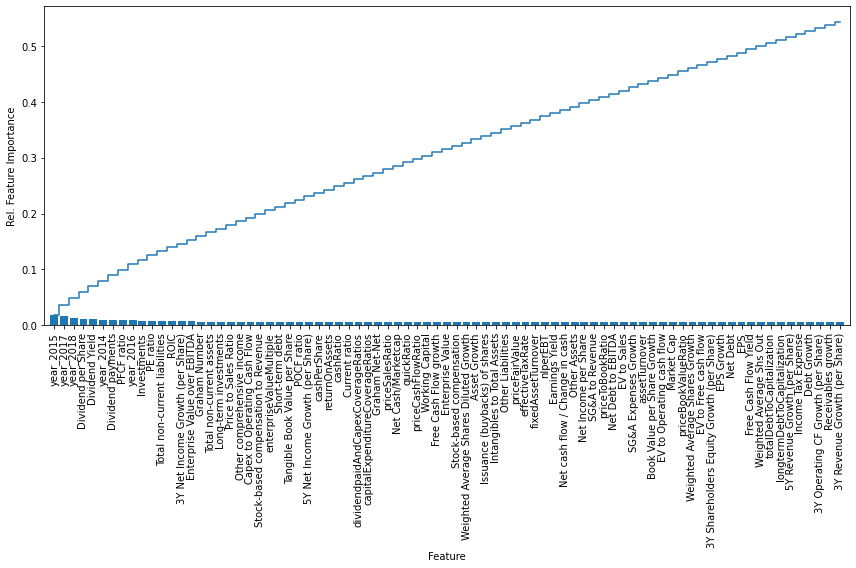

In [189]:
important_features = helper_functions.feature_selection(x = X_train, y = y_train.values.ravel(), thres=0.0055)

In [47]:
#Subset important features matrix for ML algorithms
X_train = X_train.loc[:,important_features]
X_test = X_test.loc[:, important_features]

## 3.2 ML Algorithms

### 3.2.1. Random Forest - TODO verkleinerter grid search

In [50]:
#Create classifier object and fit it to data
forest = RandomForestClassifier(criterion = 'gini', random_state = 0, n_jobs = -1)
forest.fit(X_train, y_train)

#Print test score
print('Test accuracy : {0: .4f}'.format(forest.score(X_test, y_test)))

Test accuracy :  0.6212


In [51]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#number of trees in the forest
n_estimators = np.array(range(50,60))

# Max depth
maxDepth = np.array(range(45,50))

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array(range(2,5))

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array(range(1,5))

In [ ]:
def random_forest(X_train, y_train, n_estimators, maxDepth, minSamplesNode, minSamplesLeaf):
    """ 
    This function applies Random Forest Classifier on X_train and Y_train and uses grid-cross validation on the datasets.
    :param X_train: Training Set of X values
    :param Y_train: Training Set of Y values(factorized)
    :param n_estimators: array of values which will be tested for variable n_estimators
    :param maxDepth: array of values which will be tested for variable max_depth
    :param minSamplesNode: array of values which will be tested for variable min_samples_split
    :param minSamplesLeaf: array of values which will be tested for variable min_samples_leaf
    """
    # Define the hyperparameter values to be tested
    param_grid = {"n_estimators": n_estimators,
                  'max_depth': maxDepth,
                  'min_samples_split': minSamplesNode,
                  'min_samples_leaf': minSamplesLeaf},

    # Run brute-force grid search
    grid = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv= 5, n_jobs=-1)
    grid = grid.fit(X_train, y_train)
    return(grid)

forest = random_forest(X_train,y_train, n_estimators, maxDepth, minSamplesNode, minSamplesLeaf)
print('Best CV accuracy: {:.4f}'.format(forest.best_score_))
print('Test score:       {:.4f}'.format(forest.score(X_test,y_test)))
print('Best parameters: {}'.format(forest.best_params_))

# Predict classes
y_pred = forest.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': y_test})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

2021-04-15 07:30:42.322453


### 3.2.2. MLP classifier

In [ ]:
def neural(X_train, Y_train, hidden_layer, maxIter):
    """ 
    This function applies MLP Classifier on X_train and Y_train and uses grid-cross validation on the datasets.
    :param X_train: Training Set of X values
    :param Y_train: Training Set of Y values(factorized)
    :param hidden_layer: array of values which will be tested for variable hidden_layer_sizes
    :param maxIter: array of values which will be tested for variable max_iter
        
    """

    mlp = MLPClassifier(random_state=0, solver= "lbfgs", warm_start= True)
    
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('neural', MLPClassifier())])
    
    # Define the hyperparameter values to be tested
    param_grid = {"neural__hidden_layer_sizes" : hidden_layer,
                  'neural__max_iter': maxIter},


    # Run brute-force grid search
    #solver "lbfgs" has proven to be the best
    grid = GridSearchCV(pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv= 5, n_jobs=-1)
    grid = grid.fit(X_train, Y_train)
    return(grid)

In [ ]:
#Define arrays of values to be tested for paramgrid inside GridSearchCV function

#The ith element represents the number of neurons in the ith hidden layer.
hidden_lay = np.array(range(50,500))

# Max number of iterations
max_Iter = np.array(range(150, 600))

In [ ]:
#Run MLP Classifier
mlp = neural(X_train,y_train, hidden_lay, max_Iter)

print('Best CV accuracy: {:.4f}'.format(mlp.best_score_))
print('Test score:       {:.4f}'.format(mlp.score(X_test,y_test)))
print('Best parameters: {}'.format(mlp.best_params_))

# Predict classes
y_pred = mlp.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': y_test})
print('Polynomial Kernel Function yields the following confusion matrix:')
print(confm.groupby(['True','Predicted'], sort=True).size().unstack('Predicted')) 

### 3.2.3 SVM

In [ ]:
# Create StandardScaler object
sc = StandardScaler()

# Standardize features
X_train_std = sc.fit_transform(X_train)

# Transform test set
X_test_std = sc.transform(X_test)

In [ ]:
# Create object
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear

# Fit linear SVM to standardized training set
svm_linear.fit(X_train_std, y_train)

# Print results
print("Observed probability of non-default: {:.2f}".format(np.count_nonzero(y_train==0) / len(y_train)))
print("Train score: {:.2f}".format(svm_linear.score(X_train_std, y_train)))
print("Test score:  {:.2f}".format(svm_linear.score(X_test_std, y_test)))

y_pred = svm_linear.predict(X_test_std)

# Sklearn's confusion matrix
confusion_matrix(y_test, y_pred)

In [ ]:
svm_poly = SVC(kernel='poly', random_state=1)

# Fit linear SVM to standardized training set
svm_poly.fit(X_train_std, y_train)

# Print results
print("Train score: {:.2f}".format(svm_poly.score(X_train_std, y_train)))
print("Test score:  {:.2f}".format(svm_poly.score(X_test_std, y_test)))

y_pred = svm_poly.predict(X_test_std)

# Sklearn's confusion matrix
confusion_matrix(y_test, y_pred)

In [ ]:
svm_poly_balanced = SVC(kernel='poly', random_state=1, class_weight='balanced')

# Fit linear SVM to standardized training set
svm_poly_balanced.fit(X_train_std, y_train)

# Print results
print("Train score: {:.2f}".format(svm_poly_balanced.score(X_train_std, y_train)))
print("Test score:  {:.2f}".format(svm_poly_balanced.score(X_test_std, y_test)))

y_pred = svm_poly_balanced.predict(X_test_std)

# Sklearn's confusion matrix
confusion_matrix(y_test, y_pred)

In [ ]:
# Create pipeline object with standard scaler and SVC estimator
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('svm_poly', SVC(kernel='poly', random_state=0))])

# Define parameter grid
param_grid = {'svm_poly__C': [0.1, 1],
              'svm_poly__degree': [1, 2, 3]}

# Run grid search
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_std, y_train)

# Print results
print('Best CV accuracy: {:.2f}'.format(grid.best_score_))
print('Test score:       {:.2f}'.format(grid.score(X_test, y_test)))
print('Best parameters: {}'.format(grid.best_params_))

### 3.2.4 LDA/QDA

#### 3.2.4.1 LDA

In [ ]:
lda = LDA(shrinkage='auto', solver='eigen') # default solver='svd', shrinkage=None
lda = lda.fit(X_train_lda_qda, y_train_lda_qda)

# Predict labels
y_pred_lda = lda.predict(X_test_lda_qda) # vector of 1, 2, 3s --> prediction --> in confusion matrix

# Sklearn's confusion matrix
print(metrics.confusion_matrix(y_test_lda_qda, y_pred_lda))

print('score: {0: .4f}'.format(metrics.accuracy_score(y_test_lda_qda, y_pred_lda)))
print('error-rate: {0: .4f}'.format(1-metrics.accuracy_score(y_test_lda_qda, y_pred_lda)))
print('explained variance ratio: ' + str(lda.explained_variance_ratio_)) # percentage explained of LDA by the 2 components with svd as solver



# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted status': y_pred_lda,
                      'True status': y_test_lda_qda})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True status','Predicted status']).size().unstack('Predicted status'))
print('\n')
print(metrics.classification_report(y_test_lda_qda, y_pred_lda))



In [ ]:
# LDA Gridsearch
grid = GridSearchCV(estimator=LDA(),
                  param_grid={'solver': ('lsqr', 'eigen', 'svd'), 'shrinkage': (None, 'auto')},
                  scoring='accuracy', n_jobs=-1)
grid = grid.fit(X_train, y_train)

y_pred_grid = grid.predict(X_test)

print('score: {0: .4f}'.format(metrics.accuracy_score(y_test_lda_qda, y_pred_grid)))
print('error-rate: {0: .4f}'.format(1-metrics.accuracy_score(y_test_lda_qda, y_pred_grid)))
print('\n')
print(metrics.confusion_matrix(y_test_lda_qda, y_pred_grid))
print('\n')
print(grid.best_estimator_)
# there will be a warning 'UserWarning: One or more of the test scores are non-finite' because solver='svd' can't be
# combined with shrinkage and solver='eigen' needs shrinkage

In [ ]:
lda_transformed = lda.transform(X_train_lda_qda)
colors = ['green', 'darkorange', 'red']
lw = 2
target_names = ['Buy', 'Hold', 'Sell']
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(lda_transformed[y_train_lda_qda == i, 0], lda_transformed[y_train_lda_qda == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')
plt.xlabel('Discriminant 1')
plt.ylabel('Discriminant 2')
plt.show()

In [ ]:
# Recall - correctly predicted positives for each class - when actual value is x, how often is x predicted
print('recalls: ' + str(metrics.recall_score(y_test_lda_qda, y_pred_lda, average=None)))
print('\n')

# Precision - how often is prediction correct - When a positive value is predicted, how often is the prediction correct?
print('precisions: ' + str(metrics.precision_score(y_test_lda_qda, y_pred_lda, average=None)))
print('\n')

# F1-Score
print('f1-scores: ' + str(metrics.f1_score(y_test_lda_qda, y_pred_lda, average=None)))

#### 3.2.4.2 QDA

In [ ]:
# Run qda on training data
qda = QDA().fit(X_train_lda_qda, y_train_lda_qda)

# Predict classes for qda
y_pred_qda = qda.predict(X_test_lda_qda)

# Print performance metrics
print('score qda: {0: .4f}'.format(metrics.accuracy_score(y_test_lda_qda, y_pred_qda)))
print('\n')
print(metrics.confusion_matrix(y_test_lda_qda, y_pred_qda))
print('\n')
print(metrics.classification_report(y_test_lda_qda, y_pred_qda))
print('\n')

# Recall - correctly predicted positives for each class - when actual value is x, how often is x predicted
print('recalls: ' + str(metrics.recall_score(y_test_lda_qda, y_pred_qda, average=None)))
print('\n')

# Precision - how often is prediction correct - When a positive value is predicted, how often is the prediction correct?
print('precisions: ' + str(metrics.precision_score(y_test_lda_qda, y_pred_qda, average=None)))
print('\n')

# F1-Score
print('f1-scores: ' + str(metrics.f1_score(y_test_lda_qda, y_pred_qda, average=None)))

### 3.2.5 Keras Sequential Model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

# factorize strategy column in order that the neural network is working
y_train = pd.get_dummies(y_train)

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

def base_model():
    # define the model and add layers
    model = Sequential()
    model.add(Dense(17661, input_dim=75, activation='relu'))
    model.add(Dense(122, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(3, activation ='softmax'))

    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=base_model, verbose=0)
#define the grid search parameters
batch_size = [100]
epochs = [30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# predict values with the X_test    
y_pred = grid_result.predict(X_test) 

# generate confusion_matrix and classification report for further insights
confusion_matrix(y_test, y_pred)
classification_report(y_test, y_pred)
print('\n')

# Recall - correctly predicted positives for each class - when actual value is x, how often is x predicted
print('recalls: ' + str(metrics.recall_score(y_test_lda_qda, y_pred_qda, average=None)))
print('\n')

# Precision - how often is prediction correct - When a positive value is predicted, how often is the prediction correct?
print('precisions: ' + str(metrics.precision_score(y_test_lda_qda, y_pred_qda, average=None)))
print('\n')

# F1-Score
print('f1-scores: ' + str(metrics.f1_score(y_test_lda_qda, y_pred_qda, average=None)))